In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torch.utils.data.dataset import Dataset 
import numpy as np
import glob
import torch
from PIL import Image
import cv2
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Using {device} for inference')

## 1. Dataset

In [5]:
class ImgageDataset(Dataset):
    def __init__(self, data_path, transform = None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        # self.to_tensor = transforms.ToTensor()
        self.transform = transform
        # Read the csv file
        self.data_info = pd.read_excel(data_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = '/content/drive/MyDrive/VinBigData/Project/data/after_rotated_train/samples/'+ self.image_arr[index]
        # Open image
        # img_as_img = Image.open(single_image_name)
        img_as_img = cv2.imread(single_image_name)
        # img_as_tensor = self.to_tensor(img_as_img)
        if self.transform:
          img_as_img = self.transform(img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        # single_image_label = torch.from_numpy(np.array([single_image_label]))
        

        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len


In [6]:
train_transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((128,128)),
                                transforms.Normalize((0.5,), (0.5,))])

In [7]:
test_transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((128,128)),
                                transforms.Normalize((0.5,), (0.5,))])

In [8]:
dataset = ImgageDataset('/content/drive/MyDrive/VinBigData/Project/data/after_rotated_train/new_label.xlsx', train_transform )

In [9]:
dataset. __getitem__(1)

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), 0.0)

In [10]:
dataset_size = len(dataset)
dataset_size

2274

In [11]:
indices = list(range(dataset_size))

In [12]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [13]:
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [14]:
train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [15]:
dataloaders = {'train': train_loader, 'val': validation_loader}
dataset_sizes = {'train': len(train_sampler),'val': len(valid_sampler)}

## 2. Model


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [6]:
res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [7]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

In [8]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(best_model_wts), '/content/drive/MyDrive/VinBigData/Project/flipped-img-classification.pt')

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [21]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4549 Acc: 0.7868
Iterating through data...
val Loss: 0.2051 Acc: 0.9207


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1366: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  "Positional args are being deprecated, use kwargs instead. Refer to "



Epoch 1/4
----------
Iterating through data...
train Loss: 0.1074 Acc: 0.9714
Iterating through data...
val Loss: 0.1170 Acc: 0.9537

Epoch 2/4
----------
Iterating through data...
train Loss: 0.0409 Acc: 0.9912
Iterating through data...
val Loss: 0.1070 Acc: 0.9515

Epoch 3/4
----------
Iterating through data...
train Loss: 0.0266 Acc: 0.9973
Iterating through data...
val Loss: 0.1102 Acc: 0.9537

Epoch 4/4
----------
Iterating through data...
train Loss: 0.0150 Acc: 0.9995
Iterating through data...
val Loss: 0.0989 Acc: 0.9559

Training complete in 33m 6s
Best val Acc: 0.955947


In [10]:
model1 = res_mod
model1.load_state_dict(torch.load('/content/drive/MyDrive/VinBigData/Project/flipped-img-classification.pt',  map_location=torch.device('cpu')))
# print(model1)

<All keys matched successfully>

### 3. Prediction


In [11]:
item = iter(dataloaders['val'])
imgs, labels = item.next()

NameError: ignored

In [25]:
import random

test_idx = random.choice(range(len(imgs)))

In [26]:
img = imgs[test_idx]
label = labels[test_idx]

In [27]:
label

tensor(1., dtype=torch.float64)

In [28]:
img.shape
img = torch.unsqueeze(img, dim=0) # unsqueeze data

In [29]:
# img = img.to(device)
output = model1.to('cpu')(img)
output = F.log_softmax(output, dim=1) # log softmax
pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim, dim=1
print("Predict Number : ", pred[0][0].detach().numpy()) 

Predict Number :  1


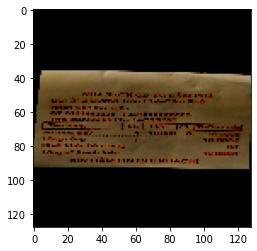

In [30]:
plt.imshow(img[0].permute((1,2,0)).cpu().numpy())
plt.show() 

In [19]:

def flip_imgage(img_path, model):
  transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((128,128)),
                                transforms.Normalize((0.5,), (0.5,))])
  img = cv2.imread(img_path)
  img1 = transform(img)
  img1 = torch.unsqueeze(img1, dim=0)
  output = model.to('cpu')(img1)
  output = F.log_softmax(output, dim=1) # log softmax
  pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim, dim=1
  # print(pred)
  if pred[0][0].detach().numpy() == 0:
    img = cv2.flip(img, 0)
    # plt.imshow(img)
    # plt.show()
    cv2.imwrite(img_path, img)
    

    


In [24]:
data = pd.read_excel('/content/drive/MyDrive/VinBigData/Project/data/after_rotated_train_original/label.xlsx', header=None)

In [25]:
image_dir = data.iloc[:,0]
label = data.iloc[:,1]


In [28]:
image_file = ['/content/drive/MyDrive/VinBigData/Project/data/after_rotated_train_original/'+ image_dir[i] for i in range(len(image_dir)) ]